# Mapping Covid-19 Positivity Rates and Testing Rates

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
pd.set_option('display.max_columns', 100)

In [31]:
# Import Chicago zip code boundaries
zip_boundaries = gpd.read_file('Boundaries - ZIP Codes/geo_export_36539c7f-c059-4101-bae4-2a14800742b8.shp')
zip_boundaries.zip = zip_boundaries.zip.astype(int)
zip_boundaries = zip_boundaries[(zip_boundaries.zip>=60601)&(zip_boundaries.zip<=60700)]
zip_boundaries.rename(columns={'zip':'ZCTA'}, inplace=True)

In [32]:
# Import complete dataframe for mapping
df = pd.read_pickle(r'complete_df.pickle')

In [33]:
baseline_pos = pd.read_csv('COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv')

In [34]:
# Removing zip codes that are not in chicago
baseline_pos = baseline_pos[(baseline_pos['ZIP Code']!= 'Unknown')]

In [35]:
# Calculate percentage to get a more granular percentage than that which is already provided in the dataset
two_wk_avg_pos = pd.DataFrame(baseline_pos.groupby(['ZIP Code'])['Cases - Weekly'].sum()/baseline_pos.groupby(['ZIP Code'])['Tests - Weekly'].sum())

In [36]:
# Convert to dataframe to merge into census dataframe
two_wk_avg_pos.reset_index(inplace=True)
two_wk_avg_pos.columns = ['ZCTA', '2weeksprior']

In [37]:
# Filling null value with 0 for zero confirmed cases in OHare (because no residents)
two_wk_avg_pos['2weeksprior'] = two_wk_avg_pos['2weeksprior'].fillna('0')

In [38]:
two_wk_avg_pos.ZCTA = two_wk_avg_pos.ZCTA.astype(int)

In [39]:
df = pd.merge(df, two_wk_avg_pos, on='ZCTA')

In [41]:
df.drop_duplicates(subset='ZCTA', inplace=True)

In [42]:
df['posRate'] = df['posRate']*100
df['testpercent'] = df['testpercent']*100

In [43]:
# Calculating percentage point difference in positivity rates between prior two weeks and most recent 2 weeks.
df['percent_change_pos_rate'] = (df['posRate'] - df['2weeksprior'])

In [44]:
complete_df = pd.merge(zip_boundaries, df, on='ZCTA')

In [45]:
complete_df = complete_df.sort_values(by='posRate')

In [57]:
complete_df[['posRate', '2weeksprior', 'percent_change_pos_rate']].describe()

,posRate,2weeksprior,percent_change_pos_rate
count,56.000000,56.000000,56.000000
mean,5.594488,0.065730,5.528758
std,2.657670,0.031908,2.630574
min,0.954154,0.019504,0.924604
25%,3.840816,0.041244,3.794331
50%,4.910147,0.058212,4.854509
75%,7.299925,0.079848,7.252655
max,12.619503,0.149418,12.473932


In [46]:
complete_df.testpercent.describe()

count    57.000000
mean      6.319983
std       2.390413
min       3.419186
25%       4.675905
50%       5.806452
75%       7.586137
max      18.110170
Name: testpercent, dtype: float64

In [47]:
complete_df.drop_duplicates(subset='ZCTA', inplace=True)

In [48]:
complete_df.head()

,objectid,shape_area,shape_len,ZCTA,geometry,totalPop,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist,testpercent,posRate,2weeksprior,percent_change_pos_rate
55,60.0,1.254243e+08,52377.854541,60637,"POLYGON ((-87.57691 41.79511, -87.57700 41.795...",47454.0,30.7,28785.0,2.467450,0.028259,0.762064,0.161841,0.042251,0.007038,0.071315,0.071880,0.065853,0.183335,0.007019,18.110170,0.954154,0.029550,0.924604
27,48.0,4.294902e+06,12245.808402,60604,"POLYGON ((-87.63376 41.87924, -87.63375 41.879...",782.0,32.4,116250.0,1.632568,0.043478,0.056266,0.634271,0.162404,0.008951,0.003836,0.057545,0.067775,0.125320,0.008123,9.590793,1.333333,0.047386,1.285948
32,19.0,4.560229e+06,13672.682289,60603,"POLYGON ((-87.61633 41.88211, -87.61635 41.882...",1174.0,28.9,151765.0,2.081560,0.097956,0.032368,0.634583,0.160136,0.000000,0.069847,0.055366,0.080068,0.231687,0.005119,5.706985,1.492537,0.019504,1.473034
8,8.0,6.656545e+07,38321.313769,60615,"POLYGON ((-87.58103 41.80421, -87.58089 41.804...",41563.0,33.8,44111.0,1.967759,0.061906,0.552222,0.301037,0.094435,0.021052,0.069929,0.048529,0.063157,0.201381,0.006392,9.623944,1.600000,0.032121,1.567879
7,1.0,4.917058e+07,33983.913306,60626,"POLYGON ((-87.66421 42.02126, -87.66419 42.021...",49730.0,34.0,40591.0,2.218406,0.206153,0.252705,0.591957,0.152725,0.070903,0.134410,0.037462,0.069897,0.267907,0.009696,8.570280,2.487095,0.044528,2.442567


In [49]:
import mapclassify as mc
from mapclassify import Quantiles, UserDefined
import contextily as ctx
import matplotlib as mpl
streets = gpd.read_file('Street Center Lines/geo_export_7dc21389-c9d3-4a8a-a9b1-8e20ca2e01dc.shp')
streets = streets[streets.geometry.notnull()]

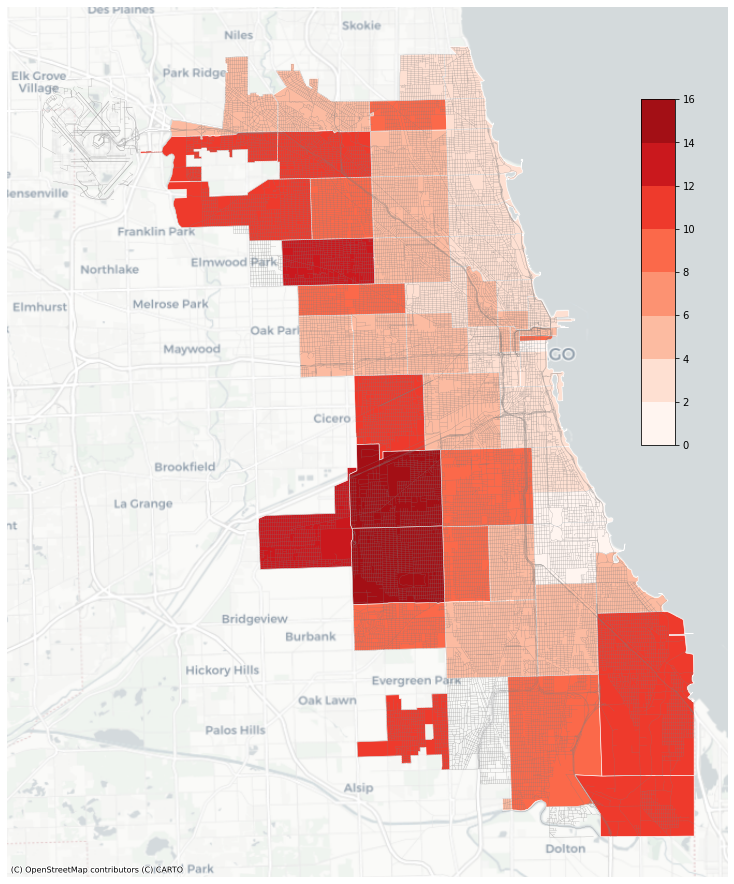

In [50]:
# Covid Positivity Rates by Zip Code

fig, ax = plt.subplots(figsize=(16,16))
streets.to_crs(epsg=26971).plot(ax=ax, color = 'grey', linewidth= 0.2)

cm = plt.get_cmap('Reds')
scheme = [cm(i / 8) for i in range(0, 8)]
bins = list(np.arange(0, 18, 2))


# labels = ['0.0 - 2.5', '2.5 - 5.0', '5.0 - 7.5', '7.5 - 10.0', '10.0 - 12.5', '12.5 - 15.0']
complete_df.to_crs(epsg=26971).assign(buckets = UserDefined(complete_df.posRate, bins).yb).plot(column='buckets', 
                                         cmap=mpl.colors.ListedColormap(scheme), linewidth=.6, edgecolor='white',
                                         categorical=True, ax=ax)
ctx.add_basemap(ax, crs='EPSG:26971', source=ctx.providers.CartoDB.Positron)
# plt.title('Chicago Positivity Rates by Zip Code', fontsize=20)
ax.axis('off')

# ax.get_legend().get_texts()[0].set_text(labels[0])
# ax.get_legend().get_texts()[1].set_text(labels[1])
# ax.get_legend().get_texts()[2].set_text(labels[2])
# ax.get_legend().get_texts()[3].set_text(labels[3])
# ax.get_legend().get_texts()[4].set_text(labels[4])
# ax.get_legend().get_texts()[5].set_text(labels[5])
# ax.get_legend().set_title('Percent Positive\n')

ax_legend = fig.add_axes([0.75, 0.5, 0.03, 0.3], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='vertical')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

#plt.axis(‘equal’)
plt.show()

In [51]:
# Top 5 Zip Codes with highest Positivity Rates
complete_df.sort_values(by='posRate', ascending=False).head()

,objectid,shape_area,shape_len,ZCTA,geometry,totalPop,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist,testpercent,posRate,2weeksprior,percent_change_pos_rate
53,58.0,2.111148e+08,58701.325375,60629,"POLYGON ((-87.68306 41.75786, -87.68306 41.757...",111850.0,31.2,42019.0,3.514312,0.710165,0.197389,0.420465,0.194099,0.187966,0.151034,0.081538,0.038820,0.281618,0.017406,4.675905,12.619503,0.145571,12.473932
51,56.0,2.117553e+08,63253.238669,60632,"POLYGON ((-87.69479 41.83008, -87.69472 41.830...",91039.0,30.9,42758.0,3.653544,0.839574,0.018563,0.517514,0.254913,0.228045,0.180299,0.047881,0.036292,0.296587,0.007247,4.371753,12.236181,0.149418,12.086763
5,39.0,1.661663e+08,67710.646739,60638,"POLYGON ((-87.74347 41.81876, -87.74346 41.818...",58797.0,37.7,67984.0,2.910887,0.517713,0.031923,0.724272,0.083865,0.057724,0.086705,0.040087,0.046567,0.306308,0.008641,4.595473,10.917839,0.112098,10.805741
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922...",90517.0,33.1,44150.0,3.539969,0.779279,0.138615,0.432659,0.220334,0.208292,0.185561,0.041694,0.054343,0.310141,0.006200,4.756013,10.685250,0.132806,10.552444
52,57.0,1.552855e+08,53406.915617,60623,"POLYGON ((-87.69479 41.83008, -87.69486 41.830...",85979.0,30.3,31634.0,3.438472,0.661371,0.312332,0.383850,0.220472,0.218995,0.213823,0.050059,0.041638,0.264099,0.003104,4.052152,9.672790,0.146985,9.525805


### Community Areas with Highest Positivity Rates
The Centers for Disease Control and the World Health Organization suggest that an area with a positivity rate above 5 percent may suggest that there is either **not enough testing in that area** or **the area is experiencing a surge in COVID transmission rates.** 
- Chicago Lawn (60629): Primarily Latinx neighborhood in Chicago (71 percent Latinx) with 12.6 percent positivity rate.
- Brighton Park (60632): Primarily Latinx Neighborhood on Southwest Side (84 percent Latinx) with 12.2 percent positivity rate.
- Clearing (60638): Primarily White and Latinx community near Midway (airport) with fairly high percentage of essential workers (30.6 percent).
- Belmont Craigin (60639): Primarily Latinx neighborhood (77.9 percent latinx) with 31.4 percent essential workers and a positivity rate of 10.7 percent.
- Little Village (60623): Primarily Mexican neighborhood on the Southwest Side (66.1 percent Latinx) with positivity rate of9.7 percent.

In [52]:
print(list(np.arange(2, 22, 2)))

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


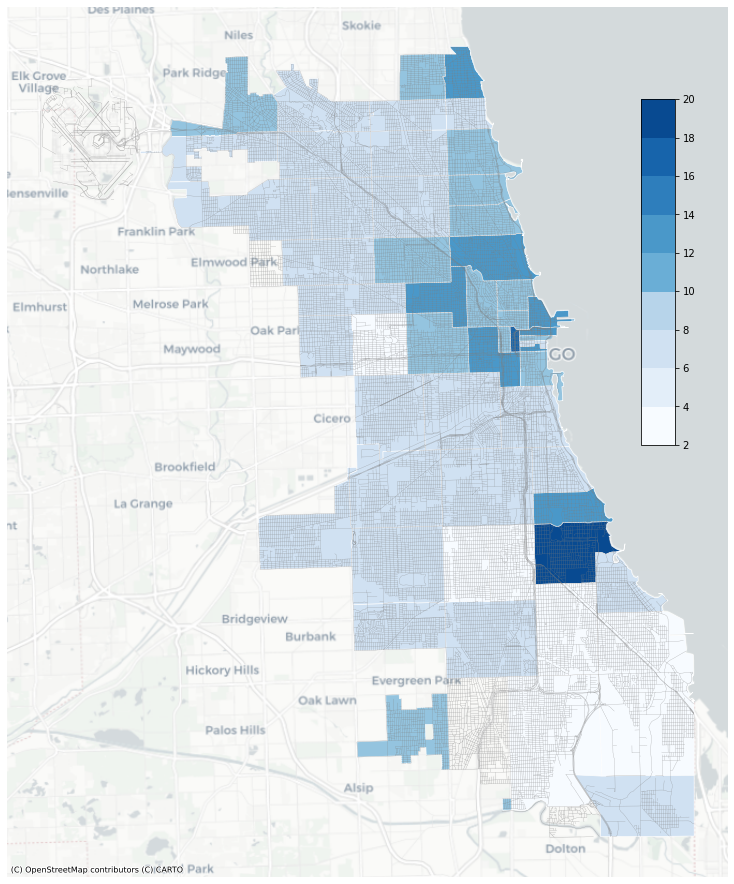

In [53]:
fig, ax = plt.subplots(figsize=(16,16))
streets.to_crs(epsg=26971).plot(ax=ax, color = 'grey', linewidth= 0.2)

cm = plt.get_cmap('Blues')
scheme = [cm(i / 10) for i in range(0, 10)]
bins = list(np.arange(2, 22, 2))
# labels = ['0.0 - 4.0', '4.0 - 8.0', '8.0 - 12.0', '12.0 - 16.0', '16.0 - 20.0']
complete_df.to_crs(epsg=26971).assign(buckets = UserDefined(complete_df.testpercent, bins).yb).plot(column='buckets', 
                                         cmap=mpl.colors.ListedColormap(scheme), linewidth=.6, edgecolor='white',
                                         categorical=True, ax=ax)
ctx.add_basemap(ax, crs='EPSG:26971', source=ctx.providers.CartoDB.Positron)
# plt.title('Chicago Testing Rates by Zip Code', fontsize=20)
ax.axis('off')


# ax.get_legend().get_texts()[0].set_text(labels[0])
# ax.get_legend().get_texts()[1].set_text(labels[1])
# ax.get_legend().get_texts()[2].set_text(labels[2])
# ax.get_legend().get_texts()[3].set_text(labels[4])
# # ax.get_legend().get_texts()[4].set_text(labels[4])
# ax.get_legend().set_title('Percent Tested\n')

ax_legend = fig.add_axes([0.75, 0.5, 0.03, 0.3], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='vertical')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

#plt.axis(‘equal’)
plt.show()


In [54]:
# Zip codes with highest testing rates
complete_df.sort_values(by='testpercent', ascending=False).head()

,objectid,shape_area,shape_len,ZCTA,geometry,totalPop,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist,testpercent,posRate,2weeksprior,percent_change_pos_rate
55,60.0,1.254243e+08,52377.854541,60637,"POLYGON ((-87.57691 41.79511, -87.57700 41.795...",47454.0,30.7,28785.0,2.467450,0.028259,0.762064,0.161841,0.042251,0.007038,0.071315,0.071880,0.065853,0.183335,0.007019,18.110170,0.954154,0.029550,0.924604
43,31.0,6.766411e+06,12040.440235,60606,"POLYGON ((-87.63397 41.88753, -87.63397 41.887...",3101.0,37.2,131477.0,1.488004,0.062883,0.023541,0.727507,0.108352,0.017736,0.023632,0.019026,0.069332,0.253467,0.006805,10.867462,4.451039,0.027554,4.423484
8,8.0,6.656545e+07,38321.313769,60615,"POLYGON ((-87.58103 41.80421, -87.58089 41.804...",41563.0,33.8,44111.0,1.967759,0.061906,0.552222,0.301037,0.094435,0.021052,0.069929,0.048529,0.063157,0.201381,0.006392,9.623944,1.600000,0.032121,1.567879
27,48.0,4.294902e+06,12245.808402,60604,"POLYGON ((-87.63376 41.87924, -87.63375 41.879...",782.0,32.4,116250.0,1.632568,0.043478,0.056266,0.634271,0.162404,0.008951,0.003836,0.057545,0.067775,0.125320,0.008123,9.590793,1.333333,0.047386,1.285948
41,29.0,6.466429e+07,39143.639517,60607,"POLYGON ((-87.63962 41.87677, -87.63928 41.876...",29591.0,30.1,93508.0,2.307650,0.083032,0.145112,0.581697,0.121152,0.009091,0.033990,0.046061,0.087155,0.239025,0.010535,8.735764,3.829787,0.050217,3.779570


### Community Areas with Highest Testing Rates
- Hyde Park/Woodlawn (UChicago Campus) (60637): Primarily Black neighborhoods home to the UChicago Campus and student body. The testing rate here is 18.1 percent - much higher than most other zip codes in the city.
- Small Sliver of Loop/West Loop (60606): Very welathy area in the downtown/financial district of the city where most residents are White and few unemployed. The tests administered in this area as a percentage of residents is 10.9 percent.
- East Hyde Park (60615): The neighborhood directly north of Hyde Park and the UChicago campus. The tetsting rate in this area is 9.6 percent.
- South Loop (60604): Area most populated by students from Roosevelt, SAIC, Columbia College, and National Louis University. These testing rate in this community is 9.6 percent.
- West Loop (60607): Upscale neighborhoods directly west of downtown home to students at UIC and medial students in the Illinois Medical District. The testing rate here is 8.7 percent.

## Mapping Percent Change in Covid Positivity Cases

The cells below are calculating the 2-week average positivity rate from the previous 2 weeks (weeks 41 and 42). 

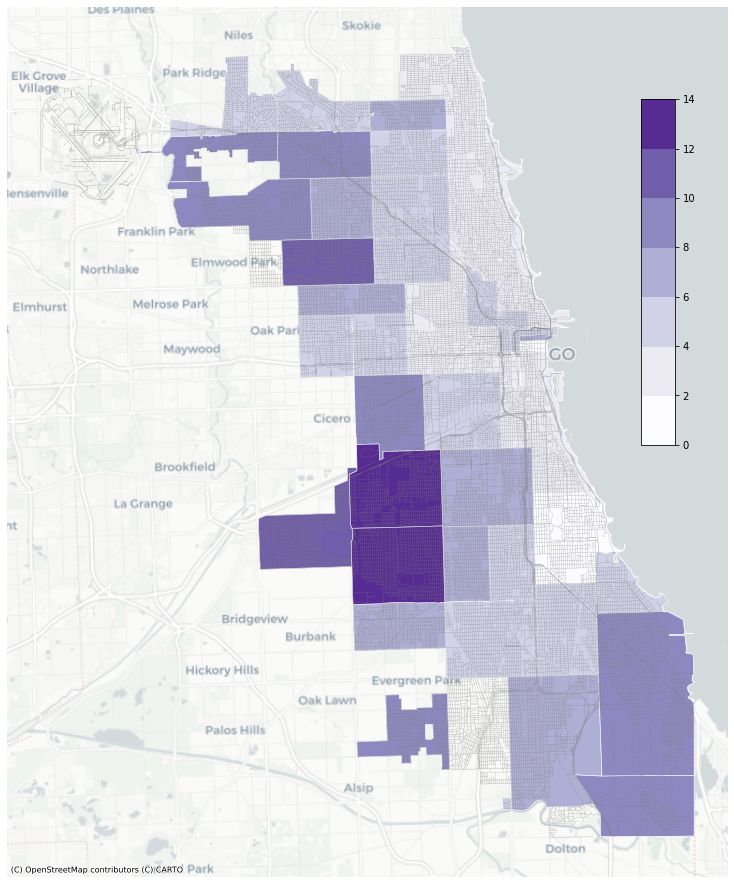

In [63]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(16,16))
streets.to_crs(epsg=26971).plot(ax=ax, color = 'grey', linewidth= 0.2)

cm = plt.get_cmap('Purples')
scheme = [cm(i / 7) for i in range(0, 7)]
bins = list(np.arange(0,16,2))

# labels = ['0.0 - 4.0', '4.0 - 8.0', '8.0 - 12.0', '12.0 - 16.0', '16.0 - 20.0']
complete_df.to_crs(epsg=26971).assign(buckets = UserDefined(complete_df.percent_change_pos_rate, bins).yb).plot(column='buckets', cmap=mpl.colors.ListedColormap(scheme), linewidth=.6, edgecolor='white',
                                         categorical=True, ax=ax)
ctx.add_basemap(ax, crs='EPSG:26971', source=ctx.providers.CartoDB.Positron)
# plt.title('Chicago Testing Rates by Zip Code', fontsize=20)
ax.axis('off')

# Making color bar
ax_legend = fig.add_axes([0.75, 0.5, 0.03, 0.3], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='vertical')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

#plt.axis(‘equal’)
plt.show()


In [62]:
complete_df.sort_values(by='percent_change_pos_rate', ascending=False).head()

,objectid,shape_area,shape_len,ZCTA,geometry,totalPop,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist,testpercent,posRate,2weeksprior,percent_change_pos_rate
53,58.0,2.111148e+08,58701.325375,60629,"POLYGON ((-87.68306 41.75786, -87.68306 41.757...",111850.0,31.2,42019.0,3.514312,0.710165,0.197389,0.420465,0.194099,0.187966,0.151034,0.081538,0.038820,0.281618,0.017406,4.675905,12.619503,0.145571,12.473932
51,56.0,2.117553e+08,63253.238669,60632,"POLYGON ((-87.69479 41.83008, -87.69472 41.830...",91039.0,30.9,42758.0,3.653544,0.839574,0.018563,0.517514,0.254913,0.228045,0.180299,0.047881,0.036292,0.296587,0.007247,4.371753,12.236181,0.149418,12.086763
5,39.0,1.661663e+08,67710.646739,60638,"POLYGON ((-87.74347 41.81876, -87.74346 41.818...",58797.0,37.7,67984.0,2.910887,0.517713,0.031923,0.724272,0.083865,0.057724,0.086705,0.040087,0.046567,0.306308,0.008641,4.595473,10.917839,0.112098,10.805741
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922...",90517.0,33.1,44150.0,3.539969,0.779279,0.138615,0.432659,0.220334,0.208292,0.185561,0.041694,0.054343,0.310141,0.006200,4.756013,10.685250,0.132806,10.552444
52,57.0,1.552855e+08,53406.915617,60623,"POLYGON ((-87.69479 41.83008, -87.69486 41.830...",85979.0,30.3,31634.0,3.438472,0.661371,0.312332,0.383850,0.220472,0.218995,0.213823,0.050059,0.041638,0.264099,0.003104,4.052152,9.672790,0.146985,9.525805


### Community Areas with Largest Increases in 2-week Average positivity Rate
- Chicago Lawn (60629): Primarily Latinx and Black neighborhood on the West side with a 12.5 percentage point increase in the 2-week average positivity rate from the start of october to the end of October. 
- Brighton Park (60632): Predominantly Latinx community on the West side with a roughly 12.1 percentage-point increase in the 2-week positivity rate.
- Clearing (60638): Primarily white neighborhood on the West side with a 10.8 percentage-point increase in 2-week average positivity rate.
- Belmont Craigin (60639): Primarily Latinx community on the West side with a 10.5 percentage-point increase in 2-week average positivity rate.
- Little Village (60623): Primarily Latinx community on the Southwest side with a 9.5 percentage-point increase in the 2-week average positivity rate.